In [34]:
# Importing libraries
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, RocCurveDisplay 

## Data cleaning

In [ ]:
# Cleaning function
def clean_data(filepath):
  '''
  This function cleans the data basing on the ideas gotten from EDA
  '''
  # Read the data
  df = pd.read_csv(filepath)

  # Dropping least correlated features ['male', 'prevalentStroke']
  df = df.drop(columns=['male', 'prevalentStroke'], axis=1)

  # Use knn imputer for filling mising values
  imputer = KNNImputer(n_neighbors=4)

  imputed = imputer.fit_transform(df)

  df = pd.DataFrame(imputed, columns=df.columns)

  # Changing 'diabetes' from float to int
  df['diabetes'] = df['diabetes'].apply(lambda x: 0 if x==0.0 else 1)

  return df

In [36]:
# Importing data
df = clean_data(r"data\framingham.csv")

In [82]:
# Overview of the data
df.head()

,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,39.0,4.0,0.0,0.0,0.0,0.0,0,195.0,106.0,70.0,26.97,80.0,77.0,0.0
1,46.0,2.0,0.0,0.0,0.0,0.0,0,250.0,121.0,81.0,28.73,95.0,76.0,0.0
2,48.0,1.0,1.0,20.0,0.0,0.0,0,245.0,127.5,80.0,25.34,75.0,70.0,0.0
3,61.0,3.0,1.0,30.0,0.0,1.0,0,225.0,150.0,95.0,28.58,65.0,103.0,1.0
4,46.0,3.0,1.0,23.0,0.0,0.0,0,285.0,130.0,84.0,23.10,85.0,85.0,0.0


## Splitting the data

In [38]:
Target = 'diabetes'

# Feature matrix
X = df.drop(Target, axis=1)

# Target vector
y = df[Target]

In [39]:
'''
Since there is no test data, we need create one
'''
# Creating partion for training and test data
X_training_partition, X_test, y_training_partition, y_test = train_test_split(X, y, test_size=0.2, random_state=256)

# Partition for the train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_training_partition, y_training_partition, test_size=0.2, random_state=256)

In [40]:
print(f"The shape of the feature matrix in the training partition is: {X_training_partition.shape}")
print(f"The shape of the target vector in the training partition is: {y_training_partition.shape}")
print(f"The shape of the feature matrix in the testing data is: {X_test.shape}")
print(f"The shape of the target vector in the testing data is: {y_test.shape}")

The shape of the feature matrix in the training partition is: (3392, 13)
The shape of the target vector in the training partition is: (3392,)
The shape of the feature matrix in the testing data is: (848, 13)
The shape of the target vector in the testing data is: (848,)


In [41]:
print(f"The shape of the feature matrix in the training data is: {X_train.shape}")
print(f"The shape of the target vector in the training data is: {y_train.shape}")
print(f"The shape of the feature matrix in the validation data is: {X_val.shape}")
print(f"The shape of the target vector in the validation data is: {y_val.shape}")

The shape of the feature matrix in the training data is: (2713, 13)
The shape of the target vector in the training data is: (2713,)
The shape of the feature matrix in the validation data is: (679, 13)
The shape of the target vector in the validation data is: (679,)


#### My PLan;
- To use the **X_train**, **y_train** for training the data and then check model performance using the validation set
- Before running the final test using the test data, I will first train it on the whole **X_training_partition** and **y_training_partition** to make sure that the model trains on enough data before finlly tessting the the model

## Model Building

#### 1. Baseline model
I will use logistic regression as the baseline model using default settings

In [42]:
# Instantiating and fitting model
lr = LogisticRegression(solver="lbfgs",max_iter=2000 ,random_state=256)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=256)

In [43]:
# Checking model performance
print(f"The performance on the training data: {lr.score(X_train, y_train)}")
print(f"The performance on the validdation data: {lr.score(X_val, y_val)}")

The performance on the training data: 0.9870991522300037
The performance on the validdation data: 0.9882179675994109


It shows that the model is performing well, but we should check the confusion marix to check this

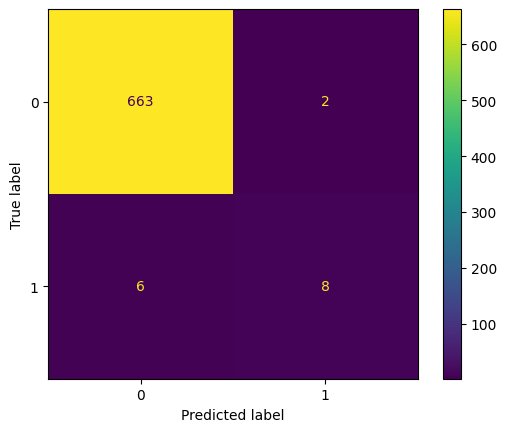

In [44]:
ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val)
plt.show()


-From the non_diabetic patients, the model predicted **663** correct and **2** incorrect 

-From the diabetic patients, **8** were predicted correct and **6** incorrect

#### 2. Iteration
We shall try to beat the baseline model performace but if the models didnt perform well, we shall go on with baseline model

In [45]:
params = {
        "n_estimators": range(100, 500, 50),
        "max_depth": range(10, 40, 10),
        "max_features": ['sqrt', 'log2', None],
        "class_weight": [None, 'balanced']
}

In [46]:
rf = RandomForestClassifier(random_state=256)
model = GridSearchCV(estimator=rf, cv=5, param_grid=params)
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=256),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': range(10, 40, 10),
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': range(100, 500, 50)})

In [62]:
# Best params from  the model
model.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=256)

In [63]:
# The performance
print(model.best_score_)

0.9863611343295753


In [64]:
# assumed best model
best_model = model.best_estimator_

In [65]:
# fitting the best model
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=256)

In [66]:
# Checking model performance
print(f"The performance on the training data: {best_model.score(X_train, y_train)}")
print(f"The performance on the validdation data: {best_model.score(X_val, y_val)}")

The performance on the training data: 1.0
The performance on the validdation data: 0.9867452135493373


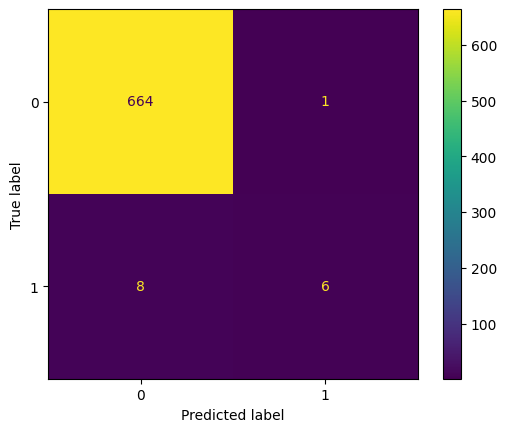

In [67]:
ConfusionMatrixDisplay.from_estimator(best_model, X_val, y_val)
plt.show()

### Communicating results
Both models performed well but I will choose the Logistic regression as the model to use

In [68]:
# before performing the predictions using the model, I will first train it on a larger data
chosen_model = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=256)
chosen_model.fit(X_training_partition, y_training_partition)

LogisticRegression(max_iter=2000, random_state=256)

In [69]:
# Making predictions with the choosen model
pred = chosen_model.predict(X_test)

In [71]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
results["performance"] = results.apply(lambda x: "correct" if x['Actual'] == x['Predicted'] else "incorrect", axis=1)

In [80]:
# Saving the model
joblib.dump(chosen_model, 'diabetes_model.pkl')

['diabetes_model.pkl']

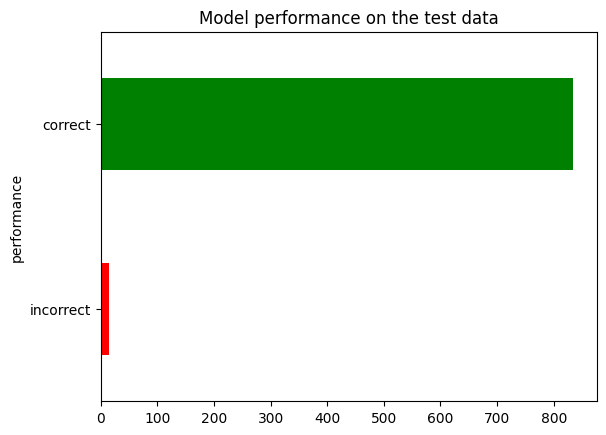

In [74]:
results['performance'].value_counts().plot(kind='barh', color=['green', 'red'])
plt.title("Model performance on the test data")
plt.gca().invert_yaxis()
plt.show()

In [85]:
# Model performance 
def model_performance(y_test, pred):
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  return accuracy, precision, recall, f1

chosen_model_performance = model_performance(y_test, pred)
print("Model performance on the test data")
print("=======================================")
print(f"Accuracy: {round(chosen_model_performance[0], 2)}")
print(f"Precision: {chosen_model_performance[1]}")
print(f"Recall: {round(chosen_model_performance[2], 2)}")
print(f"F1 score: {round(chosen_model_performance[3], 2)}")
print("=======================================")

Model performance on the test data
Accuracy: 0.98
Precision: 0.9090909090909091
Recall: 0.43
F1 score: 0.59


In [86]:
# Getting feature names and coeffivients
feature_names = X_training_partition.columns
coefficients = chosen_model.coef_[0]
odds_ratios = np.exp(coefficients)

summary_table = pd.DataFrame({'Feature': feature_names, 
                              'Coefficient': coefficients,
                              'Odds Ratio': odds_ratios})
summary_table



,Feature,Coefficient,Odds Ratio
0,age,0.021243,1.021470
1,education,0.080464,1.083790
2,currentSmoker,-0.024698,0.975604
3,cigsPerDay,-0.011835,0.988234
4,BPMeds,0.315796,1.371351
5,prevalentHyp,0.491476,1.634728
6,totChol,0.003492,1.003498
7,sysBP,0.004725,1.004736
8,diaBP,-0.020671,0.979542
9,BMI,0.070049,1.072561


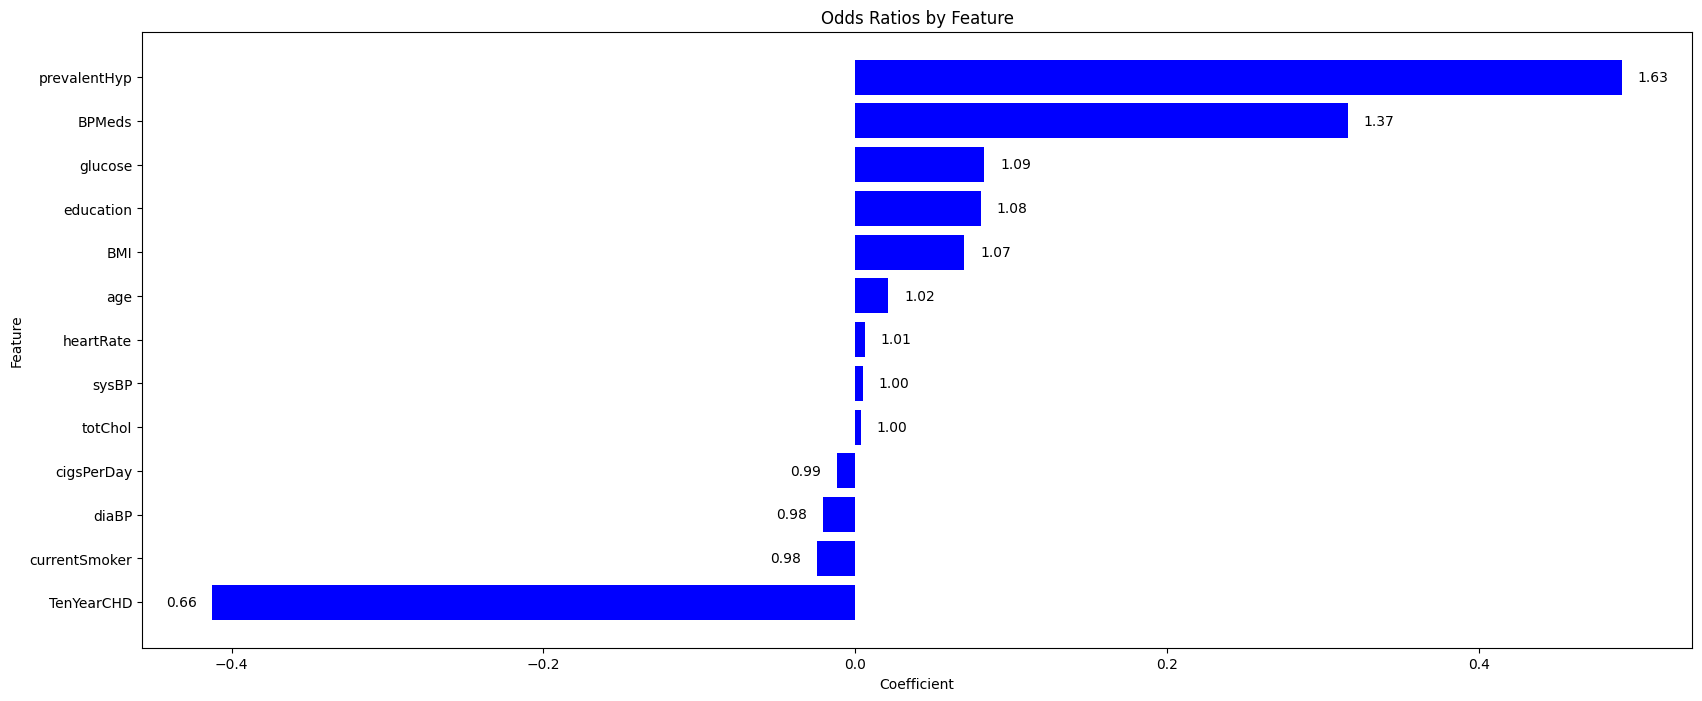

In [84]:
summary_table_sorted = summary_table.sort_values(by='Odds Ratio', ascending=True)

# Plot
plt.figure(figsize=(20, 8))
plt.barh(summary_table_sorted['Feature'], summary_table_sorted['Coefficient'], color='blue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Odds Ratios by Feature')

# Add text labels: different direction for positive and negative coefficients
for index, (coef, odds) in enumerate(zip(summary_table_sorted['Coefficient'], summary_table_sorted['Odds Ratio'])):
    if coef >= 0:
        plt.text(coef + 0.01, index, f'{odds:.2f}', va='center', ha='left', color='black')
    else:
        plt.text(coef - 0.01, index, f'{odds:.2f}', va='center', ha='right', color='black')

plt.show()
